In [1]:
# setting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer                          

from sklearn.compose import ColumnTransformer,make_column_transformer

from sklearn.decomposition import PCA



In [2]:
work_dir = '/Users/ieunpyo/PycharmProjects/Kaggle/gimhae_fire/'

train = pd.read_csv((work_dir + 'PJT002_train.csv'),encoding='utf-8' )
validation = pd.read_csv((work_dir + 'PJT002_validation .csv'),encoding='utf-8' )
test = pd.read_csv((work_dir + '/' + 'PJT002_test.csv'),encoding='utf-8')

/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,172,173,174,175,176,177,178,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1단계

### Date 변수 처리

In [3]:
def dt_of_fr_transform(df) :
    year_list = []
    month_list =  []
    day_list = []
    weekday_list = []
    hour_list = []
    
    season_list = []
    
    for i in range(len(df)) : 
        date_0=df.dt_of_fr[i].split(' ')[0] # '2017-10-20'
        time_0=df.dt_of_fr[i].split(' ')[1] # '05:54:00'
        
        year = int(date_0.split('-')[0]) # 2017
        month = int(date_0.split('-')[1]) # 10
        day = int(date_0.split('-')[2]) # 20
        weekday = datetime.date(year,month,day).weekday() # 0 : 월~ 6 : 일
        
        hour = int(time_0.split(':')[0]) # 05
        
        
        if month in [3,4,5] :
            season = 0
        elif month in [6,7,8] :
            season = 1
        elif month in [9,10,11] :
            season = 2 
        else :
            season =3
            
        year_list.append(year)
        month_list.append(month)
        day_list.append(day)
        weekday_list.append(weekday)
        season_list.append(season)
        
        hour_list.append(hour)
        
    df['year'] = year_list
    df['month'] = month_list
    df['day'] = day_list
    df['weekday'] = weekday_list
    df['season'] = season_list
    df['hour'] = hour_list
    # 다른 분들이 dt_of_fr 쓰실지 몰라서 일단은 drop 보류.
    # df = df.drop(['dt_of_fr'],axis=1)
    return df

In [4]:
# 함수 적용
train = dt_of_fr_transform(train)
test = dt_of_fr_transform(test)
validation = dt_of_fr_transform(validation)

##### 위 중에서 month, weekday, season, hour만 살려서 onehot encoding

In [5]:
# 위 중에서 month, weekday, season, hour만 살린다.
date_var = ['month','weekday','season','hour']

In [6]:
train = pd.get_dummies(train,columns=date_var)
test = pd.get_dummies(test,columns=date_var)
validation = pd.get_dummies(validation,columns=date_var)

### fr_yn 변수 처리

In [7]:
train['fr_yn'] = pd.get_dummies(train['fr_yn'])['Y']
validation['fr_yn'] = pd.get_dummies(validation['fr_yn'])['Y']

### 'rgnl_ar_nm','rgnl_ar_nm2','jmk','lnd_us_sttn_nm','rd_sd_nm'

In [8]:
def land_transform_step_1(df) :
    # rgnl_ar_nm, rgnl_ar_nm, jmk,lnd_us_sttn_nm,rd_sd_nm 행의 NA 값들을 모두 'blank'라는 새로운 범주로 지정해줌
    # (참고로 rgnl_ar_nm 이 NA인 경우 모두 rgnl_ar_nm2 값 또한 NA)
    values = {'rgnl_ar_nm': 'blank', 'rgnl_ar_nm2': 'blank','jmk':'blank','lnd_us_sttn_nm':'blank','rd_sd_nm':'blank'}
    df = df.fillna(value=values)
    
    # rgnl_ar_nm2 처리1 : rgnl_ar_nm2가 지정되지 않은 경우 그 행의 rgnl_ar_nm1의 값을 따르게 함.
    ix = df[ df['rgnl_ar_nm2']=='지정되지않음' ].index
    df.loc[ix,'rgnl_ar_nm2'] = df.loc[ix,'rgnl_ar_nm']
    return df

In [9]:
train = land_transform_step_1(train)
test = land_transform_step_1(test)
validation = land_transform_step_1(validation)

In [10]:
# train, test, validation set마다 포함하고 있는 범주가 조금씩 달라서 한번에 묶어서 기준 세움

# rgnl_ar_nm, rgnl_ar_nm2 변수의 경우 rgnl_ar_nm_uniques 가지고 fitting하도록 함.
rgnl_ar_nm_uniques = train.rgnl_ar_nm.append(train.rgnl_ar_nm2).append(test.rgnl_ar_nm).append(test.rgnl_ar_nm2).append(validation.rgnl_ar_nm).append(validation.rgnl_ar_nm2).unique()
rgnl_ar_nm_uniques = rgnl_ar_nm_uniques.reshape(-1,1)

# 'jmk','lnd_us_sttn_nm','rd_sd_nm' 또한 마찬가지
jmk_uniques = train.jmk.append(test.jmk).append(validation.jmk).unique()
jmk_uniques = jmk_uniques.reshape(-1,1)

lnd_us_sttn_nm_uniques = train.lnd_us_sttn_nm.append(test.lnd_us_sttn_nm).append(validation.lnd_us_sttn_nm).unique()
lnd_us_sttn_nm_uniques = lnd_us_sttn_nm_uniques.reshape(-1,1)

rd_sd_nm_uniques = train.rd_sd_nm.append(test.rd_sd_nm).append(validation.rd_sd_nm).unique()
rd_sd_nm_uniques = rd_sd_nm_uniques.reshape(-1,1)

'''
print(rgnl_ar_nm_uniques)
print(jmk_uniques)
print(lnd_us_sttn_nm_uniques)
print(rd_sd_nm_uniques)
'''

'\nprint(rgnl_ar_nm_uniques)\nprint(jmk_uniques)\nprint(lnd_us_sttn_nm_uniques)\nprint(rd_sd_nm_uniques)\n'

In [11]:
def land_transform_step_2(df):
    #################################################################################
    # rgnl_ar_nm, rgnl_ar_nm2 처리 
    # train, test, validation set마다 포함하고 있는 범주가 조금씩 달라서 한번에 묶어서 기준 세움
    
    oh_enc_rgnl_ar_nm = OneHotEncoder()
    oh_enc_rgnl_ar_nm.fit(rgnl_ar_nm_uniques)
    
    # category 이름 list
    cat_list_rgnl = oh_enc_rgnl_ar_nm.__dict__['categories_'][0].tolist()
    
    # encoder 들어갈 수 있게 모양 잡아줌.
    ar1 = np.array(df.rgnl_ar_nm).reshape(-1,1)
    ar2 = np.array(df.rgnl_ar_nm2).reshape(-1,1)
    
    # onehot encoding
    ar1_onehot = oh_enc_rgnl_ar_nm.transform(ar1)
    ar2_onehot = oh_enc_rgnl_ar_nm.transform(ar2)
    
    # 더해주고 2로 나누고 본 데이터에 붙이고 rgnl_ar_nm, rgnl_ar_nm2 drop
    onehot = (ar1_onehot/2+ar2_onehot/2).toarray()
    df = df.drop(['rgnl_ar_nm','rgnl_ar_nm2'],axis=1)
    df = pd.concat([df,pd.DataFrame(onehot,columns=cat_list_rgnl)],axis=1)
    
    #################################################################################
    # jmk, lnd_us_sttn_nm, rd_sd_nm 처리
    # 위와 같은 방법
    
    # jmk
    oh_enc_jmk = OneHotEncoder()
    oh_enc_jmk.fit(jmk_uniques)
    
    cat_list_jmk = oh_enc_jmk.__dict__['categories_'][0].tolist()
    jmk_arr = np.array(df.jmk).reshape(-1,1)
    jmk_onehot = oh_enc_jmk.transform(jmk_arr).toarray()
    df = df.drop(['jmk'],axis=1)
    df = pd.concat([df,pd.DataFrame(jmk_onehot,columns=cat_list_jmk)],axis=1)
    
    #lnd_us_sttn_nm
    oh_enc_lnd_us_sttn_nm = OneHotEncoder()
    oh_enc_lnd_us_sttn_nm.fit(lnd_us_sttn_nm_uniques)

    cat_list_lnd_us_sttn_nm = oh_enc_lnd_us_sttn_nm.__dict__['categories_'][0].tolist()
    lnd_us_sttn_nm_arr = np.array(df.lnd_us_sttn_nm).reshape(-1,1)
    lnd_us_sttn_nm_onehot = oh_enc_lnd_us_sttn_nm.transform(lnd_us_sttn_nm_arr).toarray()
    df = df.drop(['lnd_us_sttn_nm'],axis=1)
    df = pd.concat([df,pd.DataFrame(lnd_us_sttn_nm_onehot,columns=cat_list_lnd_us_sttn_nm)],axis=1)
    
    #rd_sd_nm
    oh_enc_rd_sd_nm = OneHotEncoder()
    oh_enc_rd_sd_nm.fit(rd_sd_nm_uniques)
    
    cat_list_rd_sd_nm = oh_enc_rd_sd_nm.__dict__['categories_'][0].tolist()
    rd_sd_nm_arr = np.array(df.rd_sd_nm).reshape(-1,1)
    rd_sd_nm_onehot = oh_enc_rd_sd_nm.transform(rd_sd_nm_arr).toarray()
    df = df.drop(['rd_sd_nm'],axis=1)
    df = pd.concat([df,pd.DataFrame(rd_sd_nm_onehot,columns=cat_list_rd_sd_nm)],axis=1)

    return df
    
    
    

In [12]:
train = land_transform_step_2(train)
test= land_transform_step_2(test)
validation = land_transform_step_2(validation)

## 지현님 파트(1단계)

* 건물 승인일자 년 단위로 자르기 함수 (소수점 포함 10자리인 글자만 찾아 자르기)

* 그 후, 2019에서 뺀 값으로 대체

In [13]:
def cut_func(x):
    if len(str(x)) == 10:
        return str(x)[:4]

In [14]:
train['dt_of_athrztn'] = train['dt_of_athrztn'].apply(cut_func)
test['dt_of_athrztn'] = test['dt_of_athrztn'].apply(cut_func)
validation['dt_of_athrztn'] = validation['dt_of_athrztn'].apply(cut_func)

In [15]:
train['dt_of_athrztn'] = pd.to_numeric(train['dt_of_athrztn'])
test['dt_of_athrztn'] = pd.to_numeric(test['dt_of_athrztn'])
validation['dt_of_athrztn'] = pd.to_numeric(validation['dt_of_athrztn'])

In [16]:
train['dt_of_athrztn'] = 2019 - train['dt_of_athrztn']
test['dt_of_athrztn'] = 2019 - test['dt_of_athrztn']
validation['dt_of_athrztn'] = 2019 - validation['dt_of_athrztn']

* 지상층, 지하층, 건물채수 카테고리화

In [17]:
train_data = [train, test, validation]

In [18]:
# 지상층 카테고리화

for dataset in train_data:
    dataset.loc[dataset['ttl_grnd_flr'] == 0, 'ttl_grnd_flr'] = 0,
    dataset.loc[(dataset['ttl_grnd_flr'] >= 1) &  (dataset['ttl_grnd_flr'] <= 10), 'ttl_grnd_flr'] = 10, 
    dataset.loc[(dataset['ttl_grnd_flr'] > 10) &  (dataset['ttl_grnd_flr'] <= 20), 'ttl_grnd_flr'] = 20,
    dataset.loc[(dataset['ttl_grnd_flr'] > 20) &  (dataset['ttl_grnd_flr'] <= 30), 'ttl_grnd_flr'] = 30,
    dataset.loc[(dataset['ttl_grnd_flr'] > 30) &  (dataset['ttl_grnd_flr'] <= 40), 'ttl_grnd_flr'] = 40,
    dataset.loc[(dataset['ttl_grnd_flr'] > 40) &  (dataset['ttl_grnd_flr'] <= 55), 'ttl_grnd_flr'] = 55,
    dataset.loc[dataset['ttl_grnd_flr'] > 55, 'ttl_grnd_flr'] = 56

In [19]:
# 지하층 카테고리화

for dataset in train_data:
    dataset.loc[dataset['ttl_dwn_flr'] == 0, 'ttl_dwn_flr'] = 0,
    dataset.loc[(dataset['ttl_dwn_flr'] >= 1) &  (dataset['ttl_dwn_flr'] <= 4), 'ttl_dwn_flr'] = 4, 
    dataset.loc[(dataset['ttl_dwn_flr'] > 4) &  (dataset['ttl_dwn_flr'] <= 10), 'ttl_dwn_flr'] = 10,
    dataset.loc[(dataset['ttl_dwn_flr'] > 10) &  (dataset['ttl_dwn_flr'] <= 20), 'ttl_dwn_flr'] = 20,
    dataset.loc[dataset['ttl_dwn_flr'] > 20, 'ttl_dwn_flr'] = 21


In [20]:
# 건물 채수 카테고리화

for dataset in train_data:
    dataset.loc[dataset['bldng_cnt'] == 0, 'bldng_cnt'] = 0,
    dataset.loc[(dataset['bldng_cnt'] >= 1) &  (dataset['bldng_cnt'] <= 5), 'bldng_cnt'] = 5, 
    dataset.loc[(dataset['bldng_cnt'] > 5) &  (dataset['bldng_cnt'] <= 10), 'bldng_cnt'] = 10,
    dataset.loc[(dataset['bldng_cnt'] > 10) &  (dataset['bldng_cnt'] <= 20), 'bldng_cnt'] = 20,
    dataset.loc[(dataset['bldng_cnt'] > 20) &  (dataset['bldng_cnt'] <= 30), 'bldng_cnt'] = 30,
    dataset.loc[dataset['bldng_cnt'] > 30, 'bldng_cnt'] = 31

----------------------------

In [21]:
# set the NA values to 'blank' and -999

train[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']] = train[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']].fillna('blank')
test[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']] = test[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']].fillna('blank')
validation[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']] = validation[['bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn']].fillna('blank')

train[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']] = train[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']].fillna(-999)
test[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']] = test[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']].fillna(-999)
validation[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']] = validation[['ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt']].fillna(-999)

    

In [22]:
# 'bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn','ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt'
# train, test, validation에서 각각 가지고 있는 총 카테고리의 수가 달라서 묶어서 한번에 피팅해주기로 함.

bldng_us_uniques = train.bldng_us.append(train.bldng_us).append(test.bldng_us).append(test.bldng_us).append(validation.bldng_us).append(validation.bldng_us).unique()
bldng_us_uniques = bldng_us_uniques.reshape(-1,1)

bldng_archtctr_uniques = train.bldng_archtctr.append(train.bldng_archtctr).append(test.bldng_archtctr).append(test.bldng_archtctr).append(validation.bldng_archtctr).append(validation.bldng_archtctr).unique()
bldng_archtctr_uniques = bldng_archtctr_uniques.reshape(-1,1)

bldng_us_clssfctn_uniques = train.bldng_us_clssfctn.append(train.bldng_us_clssfctn).append(test.bldng_us_clssfctn).append(test.bldng_us_clssfctn).append(validation.bldng_us_clssfctn).append(validation.bldng_us_clssfctn).unique()
bldng_us_clssfctn_uniques = bldng_us_clssfctn_uniques.reshape(-1,1)

ttl_grnd_flr_uniques = train.ttl_grnd_flr.append(train.ttl_grnd_flr).append(test.ttl_grnd_flr).append(test.ttl_grnd_flr).append(validation.ttl_grnd_flr).append(validation.ttl_grnd_flr).unique()
ttl_grnd_flr_uniques = ttl_grnd_flr_uniques.reshape(-1,1)

ttl_dwn_flr_uniques = train.ttl_dwn_flr.append(train.ttl_dwn_flr).append(test.ttl_dwn_flr).append(test.ttl_dwn_flr).append(validation.ttl_dwn_flr).append(validation.ttl_dwn_flr).unique()
ttl_dwn_flr_uniques = ttl_dwn_flr_uniques.reshape(-1,1)

bldng_cnt_uniques = train.bldng_cnt.append(train.bldng_cnt).append(test.bldng_cnt).append(test.bldng_cnt).append(validation.bldng_cnt).append(validation.bldng_cnt).unique()
bldng_cnt_uniques = bldng_cnt_uniques.reshape(-1,1)


In [23]:
def bldng_transform(df):
 #################################################################################
    # 'bldng_us', 'bldng_archtctr', 'bldng_us_clssfctn','ttl_grnd_flr', 'ttl_dwn_flr', 'bldng_cnt' 처리
    # 위와 같은 방법
    
    # bldng_us
    oh_enc_bldng_us = OneHotEncoder()
    oh_enc_bldng_us.fit(bldng_us_uniques)
    
    cat_list_bldng_us = oh_enc_bldng_us.__dict__['categories_'][0].tolist()
    bldng_us_arr = np.array(df.bldng_us).reshape(-1,1)
    bldng_us_onehot = oh_enc_bldng_us.transform(bldng_us_arr).toarray()
    df = df.drop(['bldng_us'],axis=1)
    df = pd.concat([df,pd.DataFrame(bldng_us_onehot,columns=cat_list_bldng_us)],axis=1)
        
    # bldng_archtctr
    oh_enc_bldng_archtctr = OneHotEncoder()
    oh_enc_bldng_archtctr.fit(bldng_archtctr_uniques)
    
    cat_list_bldng_archtctr = oh_enc_bldng_archtctr.__dict__['categories_'][0].tolist()
    bldng_archtctr_arr = np.array(df.bldng_archtctr).reshape(-1,1)
    bldng_archtctr_onehot = oh_enc_bldng_archtctr.transform(bldng_archtctr_arr).toarray()
    df = df.drop(['bldng_archtctr'],axis=1)
    df = pd.concat([df,pd.DataFrame(bldng_archtctr_onehot,columns=cat_list_bldng_archtctr)],axis=1)
    
    # bldng_us_clssfctn
    oh_enc_bldng_us_clssfctn = OneHotEncoder()
    oh_enc_bldng_us_clssfctn.fit(bldng_us_clssfctn_uniques)
    
    cat_list_bldng_us_clssfctn = oh_enc_bldng_us_clssfctn.__dict__['categories_'][0].tolist()
    bldng_us_clssfctn_arr = np.array(df.bldng_us_clssfctn).reshape(-1,1)
    bldng_us_clssfctn_onehot = oh_enc_bldng_us_clssfctn.transform(bldng_us_clssfctn_arr).toarray()
    df = df.drop(['bldng_us_clssfctn'],axis=1)
    df = pd.concat([df,pd.DataFrame(bldng_us_clssfctn_onehot,columns=cat_list_bldng_us_clssfctn)],axis=1)
    
    # ttl_grnd_flr
    oh_enc_ttl_grnd_flr = OneHotEncoder(categories='auto' )
    oh_enc_ttl_grnd_flr.fit(ttl_grnd_flr_uniques)
    
    cat_list_ttl_grnd_flr = oh_enc_ttl_grnd_flr.__dict__['categories_'][0].tolist()
    ttl_grnd_flr_arr = np.array(df.ttl_grnd_flr).reshape(-1,1)
    ttl_grnd_flr_onehot = oh_enc_ttl_grnd_flr.transform(ttl_grnd_flr_arr).toarray()
    df = df.drop(['ttl_grnd_flr'],axis=1)
    df = pd.concat([df,pd.DataFrame(ttl_grnd_flr_onehot,columns=cat_list_ttl_grnd_flr)],axis=1)
    
    # ttl_dwn_flr
    oh_enc_ttl_dwn_flr = OneHotEncoder(categories='auto' )
    oh_enc_ttl_dwn_flr.fit(ttl_dwn_flr_uniques)
    
    cat_list_ttl_dwn_flr = oh_enc_ttl_dwn_flr.__dict__['categories_'][0].tolist()
    ttl_dwn_flr_arr = np.array(df.ttl_dwn_flr).reshape(-1,1)
    ttl_dwn_flr_onehot = oh_enc_ttl_dwn_flr.transform(ttl_dwn_flr_arr).toarray()
    df = df.drop(['ttl_dwn_flr'],axis=1)
    df = pd.concat([df,pd.DataFrame(ttl_dwn_flr_onehot,columns=cat_list_ttl_dwn_flr)],axis=1)
    
    # bldng_cnt
    oh_enc_bldng_cnt = OneHotEncoder(categories='auto' )
    oh_enc_bldng_cnt.fit(bldng_cnt_uniques)
    
    cat_list_bldng_cnt = oh_enc_bldng_cnt.__dict__['categories_'][0].tolist()
    bldng_cnt_arr = np.array(df.bldng_cnt).reshape(-1,1)
    bldng_cnt_onehot = oh_enc_bldng_cnt.transform(bldng_cnt_arr).toarray()
    df = df.drop(['bldng_cnt'],axis=1)
    df = pd.concat([df,pd.DataFrame(bldng_cnt_onehot,columns=cat_list_bldng_cnt)],axis=1)
    
    return df
    
    
    

In [24]:
train = bldng_transform(train)
test = bldng_transform(test)
validation = bldng_transform(validation)

## 성호님 파트

* 도시 시골 변수 추가

In [25]:
train['emd_nm'] = train['emd_nm'].fillna(value='blank')
train.loc[train['emd_nm'].str[5:8].str.endswith('시'), 'urban'] = 'Y'
train.loc[train['emd_nm'].str[5:8].str.endswith('군'), 'urban'] = 'N'


test['emd_nm'] = test['emd_nm'].fillna(value='blank')
test.loc[test['emd_nm'].str.endswith('동'), 'urban'] = 'Y'
test.loc[test['emd_nm'].str.endswith('면'), 'urban'] = 'N'
test.loc[test['emd_nm'].str.endswith('읍'), 'urban'] = 'N'


validation['emd_nm'] = validation['emd_nm'].fillna(value='blank')
validation.loc[validation['emd_nm'].str.endswith('동'), 'urban'] = 'Y'
validation.loc[validation['emd_nm'].str.endswith('면'), 'urban'] = 'N'
validation.loc[validation['emd_nm'].str.endswith('읍'), 'urban'] = 'N'
#validation.loc[validation['emd_nm'].str.endswith('k'), 'urban'] = 'blank'


In [26]:
train = pd.get_dummies(train, prefix=['urban'],drop_first=True,columns=['urban'])
test = pd.get_dummies(test, prefix=['urban'],drop_first=True,columns=['urban'])
validation =pd.get_dummies(validation, prefix=['urban'],drop_first=True,columns=['urban'])

sh_var = ['fr_sttn_dstnc', 'bldng_ar_prc', 'fr_wthr_fclt_dstnc', 'fr_mn_cnt', 'mlt_us_yn', 'cctv_dstnc', 'cctv_in_100m', 'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 
               'sft_emrgnc_bll_dstnc', 'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'trgt_crtr', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 
               'us_yn', 'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn']


sh_cat_var = ['mlt_us_yn','trgt_crtr', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 
               'us_yn', 'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn'] 

In [27]:
sh_cat_var = ['mlt_us_yn','trgt_crtr', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 
              'us_yn', 'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn']

sh_num_var = ['fr_sttn_dstnc', 'bldng_ar_prc', 'fr_wthr_fclt_dstnc', 'fr_mn_cnt',
          'cctv_dstnc', 'cctv_in_100m', 'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 
          'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m']+['hm_cnt']

sh_var = sh_cat_var + sh_num_var

##### hm_cnt의 경우도 같이 imputation 해주면 좋을 것 같아서 sh_num_var 에 같이 넣어서 후에 pipeline도 같이 채웠습니다!!!

### 성호님 파트 중 categorical data 먼저 처리

In [28]:
print(sh_cat_var)

['mlt_us_yn', 'trgt_crtr', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 'us_yn', 'dngrs_thng_yn', 'slf_fr_brgd_yn', 'blk_dngrs_thng_mnfctr_yn', 'cltrl_hrtg_yn']


In [29]:
# set the NA values to 'blank'

train[sh_cat_var] = train[sh_cat_var].fillna('blank')
test[sh_cat_var] = test[sh_cat_var].fillna('blank')
validation[sh_cat_var] = validation[sh_cat_var].fillna('blank')

In [30]:
mlt_us_yn_uniques = train.mlt_us_yn.append(train.mlt_us_yn).append(test.mlt_us_yn).append(test.mlt_us_yn).append(validation.mlt_us_yn).append(validation.mlt_us_yn).unique()
mlt_us_yn_uniques = mlt_us_yn_uniques.reshape(-1,1)

trgt_crtr_uniques = train.trgt_crtr.append(train.trgt_crtr).append(test.trgt_crtr).append(test.trgt_crtr).append(validation.trgt_crtr).append(validation.trgt_crtr).unique()
trgt_crtr_uniques = trgt_crtr_uniques.reshape(-1,1)

fr_fghtng_fclt_spcl_css_5_yn_uniques = train.fr_fghtng_fclt_spcl_css_5_yn.append(train.fr_fghtng_fclt_spcl_css_5_yn).append(test.fr_fghtng_fclt_spcl_css_5_yn).append(test.fr_fghtng_fclt_spcl_css_5_yn).append(validation.fr_fghtng_fclt_spcl_css_5_yn).append(validation.fr_fghtng_fclt_spcl_css_5_yn).unique()
fr_fghtng_fclt_spcl_css_5_yn_uniques = fr_fghtng_fclt_spcl_css_5_yn_uniques.reshape(-1,1)

fr_fghtng_fclt_spcl_css_6_yn_uniques = train.fr_fghtng_fclt_spcl_css_6_yn.append(train.fr_fghtng_fclt_spcl_css_6_yn).append(test.fr_fghtng_fclt_spcl_css_6_yn).append(test.fr_fghtng_fclt_spcl_css_6_yn).append(validation.fr_fghtng_fclt_spcl_css_6_yn).append(validation.fr_fghtng_fclt_spcl_css_6_yn).unique()
fr_fghtng_fclt_spcl_css_6_yn_uniques = fr_fghtng_fclt_spcl_css_6_yn_uniques.reshape(-1,1)

us_yn_uniques = train.us_yn.append(train.us_yn).append(test.us_yn).append(test.us_yn).append(validation.us_yn).append(validation.us_yn).unique()
us_yn_uniques = us_yn_uniques.reshape(-1,1)

dngrs_thng_yn_uniques = train.dngrs_thng_yn.append(train.dngrs_thng_yn).append(test.dngrs_thng_yn).append(test.dngrs_thng_yn).append(validation.dngrs_thng_yn).append(validation.dngrs_thng_yn).unique()
dngrs_thng_yn_uniques = dngrs_thng_yn_uniques.reshape(-1,1)

slf_fr_brgd_yn_uniques = train.slf_fr_brgd_yn.append(train.slf_fr_brgd_yn).append(test.slf_fr_brgd_yn).append(test.slf_fr_brgd_yn).append(validation.slf_fr_brgd_yn).append(validation.slf_fr_brgd_yn).unique()
slf_fr_brgd_yn_uniques = slf_fr_brgd_yn_uniques.reshape(-1,1)

blk_dngrs_thng_mnfctr_yn_uniques = train.blk_dngrs_thng_mnfctr_yn.append(train.blk_dngrs_thng_mnfctr_yn).append(test.blk_dngrs_thng_mnfctr_yn).append(test.blk_dngrs_thng_mnfctr_yn).append(validation.blk_dngrs_thng_mnfctr_yn).append(validation.blk_dngrs_thng_mnfctr_yn).unique()
blk_dngrs_thng_mnfctr_yn_uniques = blk_dngrs_thng_mnfctr_yn_uniques.reshape(-1,1)

cltrl_hrtg_yn_uniques = train.cltrl_hrtg_yn.append(train.cltrl_hrtg_yn).append(test.cltrl_hrtg_yn).append(test.cltrl_hrtg_yn).append(validation.cltrl_hrtg_yn).append(validation.cltrl_hrtg_yn).unique()
cltrl_hrtg_yn_uniques = cltrl_hrtg_yn_uniques.reshape(-1,1)


In [31]:
def sh_cat_transform(df):
 #################################################################################
 # mlt_us_yn
    oh_enc_mlt_us_yn = OneHotEncoder()
    oh_enc_mlt_us_yn.fit(mlt_us_yn_uniques)
    
    cat_list_mlt_us_yn = oh_enc_mlt_us_yn.__dict__['categories_'][0].tolist()
    mlt_us_yn_arr = np.array(df.mlt_us_yn).reshape(-1,1)
    mlt_us_yn_onehot = oh_enc_mlt_us_yn.transform(mlt_us_yn_arr).toarray()
    df = df.drop(['mlt_us_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(mlt_us_yn_onehot,columns=cat_list_mlt_us_yn)],axis=1)

    # trgt_crtr
    oh_enc_trgt_crtr = OneHotEncoder()
    oh_enc_trgt_crtr.fit(trgt_crtr_uniques)
    
    cat_list_trgt_crtr = oh_enc_trgt_crtr.__dict__['categories_'][0].tolist()
    trgt_crtr_arr = np.array(df.trgt_crtr).reshape(-1,1)
    trgt_crtr_onehot = oh_enc_trgt_crtr.transform(trgt_crtr_arr).toarray()
    df = df.drop(['trgt_crtr'],axis=1)
    df = pd.concat([df,pd.DataFrame(trgt_crtr_onehot,columns=cat_list_trgt_crtr)],axis=1)

    
    # fr_fghtng_fclt_spcl_css_5_yn
    oh_enc_fr_fghtng_fclt_spcl_css_5_yn = OneHotEncoder()
    oh_enc_fr_fghtng_fclt_spcl_css_5_yn.fit(fr_fghtng_fclt_spcl_css_5_yn_uniques)
    
    cat_list_fr_fghtng_fclt_spcl_css_5_yn = oh_enc_fr_fghtng_fclt_spcl_css_5_yn.__dict__['categories_'][0].tolist()
    fr_fghtng_fclt_spcl_css_5_yn_arr = np.array(df.fr_fghtng_fclt_spcl_css_5_yn).reshape(-1,1)
    fr_fghtng_fclt_spcl_css_5_yn_onehot = oh_enc_fr_fghtng_fclt_spcl_css_5_yn.transform(fr_fghtng_fclt_spcl_css_5_yn_arr).toarray()
    df = df.drop(['fr_fghtng_fclt_spcl_css_5_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(fr_fghtng_fclt_spcl_css_5_yn_onehot,columns=cat_list_fr_fghtng_fclt_spcl_css_5_yn)],axis=1)

    # fr_fghtng_fclt_spcl_css_6_yn
    oh_enc_fr_fghtng_fclt_spcl_css_6_yn = OneHotEncoder()
    oh_enc_fr_fghtng_fclt_spcl_css_6_yn.fit(fr_fghtng_fclt_spcl_css_6_yn_uniques)
    
    cat_list_fr_fghtng_fclt_spcl_css_6_yn = oh_enc_fr_fghtng_fclt_spcl_css_6_yn.__dict__['categories_'][0].tolist()
    fr_fghtng_fclt_spcl_css_6_yn_arr = np.array(df.fr_fghtng_fclt_spcl_css_6_yn).reshape(-1,1)
    fr_fghtng_fclt_spcl_css_6_yn_onehot = oh_enc_fr_fghtng_fclt_spcl_css_6_yn.transform(fr_fghtng_fclt_spcl_css_6_yn_arr).toarray()
    df = df.drop(['fr_fghtng_fclt_spcl_css_6_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(fr_fghtng_fclt_spcl_css_6_yn_onehot,columns=cat_list_fr_fghtng_fclt_spcl_css_6_yn)],axis=1)

    # us_yn
    oh_enc_us_yn = OneHotEncoder()
    oh_enc_us_yn.fit(us_yn_uniques)
    
    cat_list_us_yn = oh_enc_us_yn.__dict__['categories_'][0].tolist()
    us_yn_arr = np.array(df.us_yn).reshape(-1,1)
    us_yn_onehot = oh_enc_us_yn.transform(us_yn_arr).toarray()
    df = df.drop(['us_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(us_yn_onehot,columns=cat_list_us_yn)],axis=1)

    # dngrs_thng_yn
    oh_enc_dngrs_thng_yn = OneHotEncoder()
    oh_enc_dngrs_thng_yn.fit(dngrs_thng_yn_uniques)
    
    cat_list_dngrs_thng_yn = oh_enc_dngrs_thng_yn.__dict__['categories_'][0].tolist()
    dngrs_thng_yn_arr = np.array(df.dngrs_thng_yn).reshape(-1,1)
    dngrs_thng_yn_onehot = oh_enc_dngrs_thng_yn.transform(dngrs_thng_yn_arr).toarray()
    df = df.drop(['dngrs_thng_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(dngrs_thng_yn_onehot,columns=cat_list_dngrs_thng_yn)],axis=1)

    # slf_fr_brgd_yn
    oh_enc_slf_fr_brgd_yn = OneHotEncoder()
    oh_enc_slf_fr_brgd_yn.fit(slf_fr_brgd_yn_uniques)
    
    cat_list_slf_fr_brgd_yn = oh_enc_slf_fr_brgd_yn.__dict__['categories_'][0].tolist()
    slf_fr_brgd_yn_arr = np.array(df.slf_fr_brgd_yn).reshape(-1,1)
    slf_fr_brgd_yn_onehot = oh_enc_slf_fr_brgd_yn.transform(slf_fr_brgd_yn_arr).toarray()
    df = df.drop(['slf_fr_brgd_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(slf_fr_brgd_yn_onehot,columns=cat_list_slf_fr_brgd_yn)],axis=1)

    # blk_dngrs_thng_mnfctr_yn
    oh_enc_blk_dngrs_thng_mnfctr_yn = OneHotEncoder()
    oh_enc_blk_dngrs_thng_mnfctr_yn.fit(blk_dngrs_thng_mnfctr_yn_uniques)
    
    cat_list_blk_dngrs_thng_mnfctr_yn = oh_enc_blk_dngrs_thng_mnfctr_yn.__dict__['categories_'][0].tolist()
    blk_dngrs_thng_mnfctr_yn_arr = np.array(df.blk_dngrs_thng_mnfctr_yn).reshape(-1,1)
    blk_dngrs_thng_mnfctr_yn_onehot = oh_enc_blk_dngrs_thng_mnfctr_yn.transform(blk_dngrs_thng_mnfctr_yn_arr).toarray()
    df = df.drop(['blk_dngrs_thng_mnfctr_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(blk_dngrs_thng_mnfctr_yn_onehot,columns=cat_list_blk_dngrs_thng_mnfctr_yn)],axis=1)

   # cltrl_hrtg_yn
    oh_enc_cltrl_hrtg_yn = OneHotEncoder()
    oh_enc_cltrl_hrtg_yn.fit(cltrl_hrtg_yn_uniques)
    
    cat_list_cltrl_hrtg_yn = oh_enc_cltrl_hrtg_yn.__dict__['categories_'][0].tolist()
    cltrl_hrtg_yn_arr = np.array(df.cltrl_hrtg_yn).reshape(-1,1)
    cltrl_hrtg_yn_onehot = oh_enc_cltrl_hrtg_yn.transform(cltrl_hrtg_yn_arr).toarray()
    df = df.drop(['cltrl_hrtg_yn'],axis=1)
    df = pd.concat([df,pd.DataFrame(cltrl_hrtg_yn_onehot,columns=cat_list_cltrl_hrtg_yn)],axis=1)

    return df
    
    
    

In [32]:
train = sh_cat_transform(train)
validation = sh_cat_transform(validation)
test = sh_cat_transform(test)

In [33]:
print(train.shape)
print(test.shape)
print(validation.shape)

(59199, 440)
(2957, 440)
(6898, 440)


### 성호님 파트 중 numerical data 처리


In [34]:
print (sh_num_var)

['fr_sttn_dstnc', 'bldng_ar_prc', 'fr_wthr_fclt_dstnc', 'fr_mn_cnt', 'cctv_dstnc', 'cctv_in_100m', 'fr_wthr_fclt_in_100m', 'tbc_rtl_str_dstnc', 'sft_emrgnc_bll_dstnc', 'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m', 'hm_cnt']


In [35]:
train_plus_validation_sh_num = train[sh_num_var].append(validation[sh_num_var])
train_plus_validation_sh_num.head()

,fr_sttn_dstnc,bldng_ar_prc,fr_wthr_fclt_dstnc,fr_mn_cnt,cctv_dstnc,cctv_in_100m,fr_wthr_fclt_in_100m,tbc_rtl_str_dstnc,sft_emrgnc_bll_dstnc,ahsm_dstnc,no_tbc_zn_dstnc,bldng_cnt_in_50m,hm_cnt
0,4547,NaN,133,137.0,112,0,0,1891,29231,11322,88,0,17360.0
1,6388,122581.0,489,85.0,818,0,0,4533,20480,3369,7727,0,1791.0
2,3340,618105.0,143,137.0,165,0,0,277,31197,12451,72,14,17285.0
3,179,719542.0,1585,176.0,131,0,0,438,4270,407,508,11,7327.0
4,4822,NaN,603,137.0,686,0,0,1702,29778,12487,707,0,17278.0


In [36]:
imputer_sh = IterativeImputer()

imputed_sh_num_train_validation=imputer_sh.fit_transform(train_plus_validation_sh_num)
imputed_sh_num_test=imputer_sh.transform(test[sh_num_var])

In [37]:
train[sh_num_var]=imputed_sh_num_train_validation[:train.shape[0],:]
validation[sh_num_var]=imputed_sh_num_train_validation[train.shape[0]:,:]

test[sh_num_var] = imputed_sh_num_test

In [38]:
print(train.shape)
print(test.shape)
print(validation.shape)

(59199, 440)
(2957, 440)
(6898, 440)


# 2단계

## ColumnTransformer 위한 변수 정의

In [41]:
weather_var_1 = ['prcpttn']
weather_var_2 = ['tmprtr','wnd_spd','wnd_drctn','hmdt'] 
weather_var = weather_var_1 + weather_var_2

eg_var = train.loc[:,'gas_engry_us_201401':'ele_engry_us_201812'].keys().tolist()
lw_var = train.loc[:,'lw_13101010':'lw_13141011'] .keys().tolist()
egl_var = eg_var + lw_var # 모든 관심변수들

building_numeric_feature = ['bldng_ar', 'ttl_ar', 'lnd_ar']
building_date = ['dt_of_athrztn']



numerical_feature = ['hm_cnt', 'ahsm_dstnc', 'no_tbc_zn_dstnc', 'bldng_cnt_in_50m']
price_feature = ['bldng_ar_prc']

date_var = date_var # to be one-hot coded / 앞에서 지정

sh_num_var = sh_num_var # 앞에서 지정

drop_var =['dt_of_fr','fr_yn','id', 'emd_nm','year','day']



select_var = (weather_var_1 + weather_var_2 + eg_var + lw_var + building_numeric_feature +
             building_date + sh_num_var+ price_feature + sh_num_var + date_var)

In [40]:
# urban_feature = ['mlt_us_yn']

In [42]:
train_2 = train.drop(drop_var,axis=1)
test_2 = test.drop(drop_var,axis=1)
validation_2 = validation.drop(drop_var,axis=1)


In [43]:
list(train_2.keys())

['bldng_ar',
 'ttl_ar',
 'lnd_ar',
 'dt_of_athrztn',
 'tmprtr',
 'prcpttn',
 'wnd_spd',
 'wnd_drctn',
 'hmdt',
 'gas_engry_us_201401',
 'ele_engry_us_201401',
 'gas_engry_us_201402',
 'ele_engry_us_201402',
 'gas_engry_us_201403',
 'ele_engry_us_201403',
 'gas_engry_us_201404',
 'ele_engry_us_201404',
 'gas_engry_us_201405',
 'ele_engry_us_201405',
 'gas_engry_us_201406',
 'ele_engry_us_201406',
 'gas_engry_us_201407',
 'ele_engry_us_201407',
 'gas_engry_us_201408',
 'ele_engry_us_201408',
 'gas_engry_us_201409',
 'ele_engry_us_201409',
 'gas_engry_us_201410',
 'ele_engry_us_201410',
 'gas_engry_us_201411',
 'ele_engry_us_201411',
 'gas_engry_us_201412',
 'ele_engry_us_201412',
 'gas_engry_us_201501',
 'ele_engry_us_201501',
 'gas_engry_us_201502',
 'ele_engry_us_201502',
 'gas_engry_us_201503',
 'ele_engry_us_201503',
 'gas_engry_us_201504',
 'ele_engry_us_201504',
 'gas_engry_us_201505',
 'ele_engry_us_201505',
 'gas_engry_us_201506',
 'ele_engry_us_201506',
 'gas_engry_us_201507',
 

In [44]:
train_2.iloc[0:3,156]

0    0
1    0
2    0
Name: month_1, dtype: uint8

##### 0~155번까지 변수는 파이프라인 탈 변수들 -> train_2, validation_2, test_2
##### 뒤 부분(156~ 변수들)은 모두 pandas에서 미리 원핫처리해준 변수들 -> train_3, validation_3, test_3
##### 마지막에 np.c_[dataset_2,dataset_3] 로 합친 뒤 모델에 투입


In [45]:
train_3 = np.array(train_2.iloc[:,156:])
test_3 = np.array(test_2.iloc[:,156:])
validation_3 = np.array(validation_2.iloc[:,156:])

## Weather Pipeline

##### 'tmprtr','prcpttn','wnd_spd','wnd_drctn','hmdt'

In [47]:
weather_imputer = ColumnTransformer([
    ('prcpttn_imputer',SimpleImputer(strategy='constant',fill_value=-1),weather_var_1),
    ('otehrs_imputer',IterativeImputer(),weather_var_2)
     ])

weather_scale_PCA = Pipeline([
    ('Scaler',StandardScaler()),
    ('PCA',PCA())
])

weather_pipe = Pipeline([
    ('weather_imputer',weather_imputer),
    ('weather_scale_PCA',weather_scale_PCA)
    
])

## Gas, Ele, Lw Pipeline


###  불이 난 달의 Gas와 Ele 사용량을 열으로 추가하는 변환기를 정의합니다. 



In [48]:
# Train

class TrFmGEAdder(BaseEstimator, TransformerMixin):
  def __init__(self, index = eg_var):
    self.index = ['dt_of_fr'] + index
  
  def fit(self, X,y = None):
    return(self)
  
  def transform(self, X, y = None):
    index = self.index
    X = np.append(np.array(train['dt_of_fr']).reshape(-1,1), X, axis = 1) # X를 받아서 앞에 dt_of_fr열을 추가합니다.
    X = pd.DataFrame(X) # 차후 열 이름을 기준으로 사용해야 하기 때문에 Pandas로 변환합니다. 
    X.columns = train[['dt_of_fr']+eg_var].keys() # 열 이름을 추가합니다. eg_var 대상으로 진행할 것이기 때문에 이렇게 씁니다.

    train_rst = X.assign(
        fr_month_gas  = 'gas'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
        ).assign(
            fr_month_ele  = 'ele'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
            ) # gas/ele + 불이 난 달을 값으로 갖는 열을 생성합니다. 이걸 생성하지 않고 하는 것도 할 수 있을거 같은데 지금은 뇌가 멈췄으니 일단 만듭니다.
    
    tk = train_rst.keys()[np.where(pd.Series(train_rst.keys()) == index[0])[0][0]:np.where(pd.Series(train_rst.keys()) == index[-1])[0][0]+1]
    keys = pd.Series(tk).str.split('_', expand = True).iloc[:,[0,3]]
    keys[1] = keys[0]+keys[3]
    keys[1][0] = 'dt_of_fr' # 변경된 열 이름의 리스트입니다. 가장 앞의 값이 누락되어서 추가해주었습니다.
    
    coln = keys[1].ravel().tolist()+['fr_month_gas','fr_month_ele'] #열 이름을 바꿔줄 준비. 앞선 fr_month_gas/ ele열을 index로 사용하기 위함입니다
    train_rst.columns = coln #열 이름 변경합니다.

    fm_gas_index = train_rst.fr_month_gas.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 gas의 열 index
    fm_ele_index = train_rst.fr_month_ele.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 ele의 열 index

    train_eg = train_rst.assign(
        gas_fm = np.array(train_rst)[np.arange(train.shape[0]),fm_gas_index.values] # 최종적으로 두 index를 기준으로 값을 대입합니다.
        ).assign(
            ele_fm = np.array(train_rst)[np.arange(train.shape[0]),fm_ele_index.values]
            )[['gas_fm','ele_fm']] # 이 두 열만 남기거나
            #.drop(['fr_month_gas','fr_month_ele','dt_of_fr'], axis = 1) # 이 두 열을 더하거나. 일단은 두 열만 남겼습니다. 
    
    return np.array(train_eg)

In [49]:
#  Val. 

class VFmGEAdder(BaseEstimator, TransformerMixin):
  def __init__(self, index = eg_var):
    self.index = ['dt_of_fr'] + index
  
  def fit(self, X,y = None):
    return(self)
  
  def transform(self, X, y = None):
    index = self.index
    X = np.append(np.array(validation['dt_of_fr']).reshape(-1,1), X, axis = 1) # X를 받아서 앞에 dt_of_fr열을 추가합니다.
    X = pd.DataFrame(X) # 차후 열 이름을 기준으로 사용해야 하기 때문에 Pandas로 변환합니다. 
    X.columns = validation[['dt_of_fr']+eg_var].keys() # 열 이름을 추가합니다. eg_var 대상으로 진행할 것이기 때문에 이렇게 씁니다.

    train_rst = X.assign(
        fr_month_gas  = 'gas'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
        ).assign(
            fr_month_ele  = 'ele'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
            ) # gas/ele + 불이 난 달을 값으로 갖는 열을 생성합니다. 이걸 생성하지 않고 하는 것도 할 수 있을거 같은데 지금은 뇌가 멈췄으니 일단 만듭니다.
    
    tk = train_rst.keys()[np.where(pd.Series(train_rst.keys()) == index[0])[0][0]:np.where(pd.Series(train_rst.keys()) == index[-1])[0][0]+1]
    keys = pd.Series(tk).str.split('_', expand = True).iloc[:,[0,3]]
    keys[1] = keys[0]+keys[3]
    keys[1][0] = 'dt_of_fr' # 변경된 열 이름의 리스트입니다. 가장 앞의 값이 누락되어서 추가해주었습니다.
    
    coln = keys[1].ravel().tolist()+['fr_month_gas','fr_month_ele'] #열 이름을 바꿔줄 준비. 앞선 fr_month_gas/ ele열을 index로 사용하기 위함입니다
    train_rst.columns = coln #열 이름 변경합니다.

    fm_gas_index = train_rst.fr_month_gas.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 gas의 열 index
    fm_ele_index = train_rst.fr_month_ele.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 ele의 열 index

    train_eg = train_rst.assign(
        gas_fm = np.array(train_rst)[np.arange(validation.shape[0]),fm_gas_index.values] # 최종적으로 두 index를 기준으로 값을 대입합니다.
        ).assign(
            ele_fm = np.array(train_rst)[np.arange(validation.shape[0]),fm_ele_index.values]
            )[['gas_fm','ele_fm']] # 이 두 열만 남기거나
            #.drop(['fr_month_gas','fr_month_ele','dt_of_fr'], axis = 1) # 이 두 열을 더하거나. 일단은 두 열만 남겼습니다. 
    
    return np.array(train_eg)

In [50]:
# Test 

class TeFmGEAdder(BaseEstimator, TransformerMixin):
  def __init__(self, index = eg_var):
    self.index = ['dt_of_fr'] + index
  
  def fit(self, X,y = None):
    return(self)
  
  def transform(self, X, y = None):
    index = self.index
    X = np.append(np.array(test['dt_of_fr']).reshape(-1,1), X, axis = 1) # X를 받아서 앞에 dt_of_fr열을 추가합니다.
    X = pd.DataFrame(X) # 차후 열 이름을 기준으로 사용해야 하기 때문에 Pandas로 변환합니다. 
    X.columns = test[['dt_of_fr']+eg_var].keys() # 열 이름을 추가합니다. eg_var 대상으로 진행할 것이기 때문에 이렇게 씁니다.

    train_rst = X.assign(
        fr_month_gas  = 'gas'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
        ).assign(
            fr_month_ele  = 'ele'+X['dt_of_fr'].str.slice_replace(start=7, stop=20, repl='').str.replace(pat='-', repl='', regex=False)
            ) # gas/ele + 불이 난 달을 값으로 갖는 열을 생성합니다. 이걸 생성하지 않고 하는 것도 할 수 있을거 같은데 지금은 뇌가 멈췄으니 일단 만듭니다.
    
    tk = train_rst.keys()[np.where(pd.Series(train_rst.keys()) == index[0])[0][0]:np.where(pd.Series(train_rst.keys()) == index[-1])[0][0]+1]
    keys = pd.Series(tk).str.split('_', expand = True).iloc[:,[0,3]]
    keys[1] = keys[0]+keys[3]
    keys[1][0] = 'dt_of_fr' # 변경된 열 이름의 리스트입니다. 가장 앞의 값이 누락되어서 추가해주었습니다.
    
    coln = keys[1].ravel().tolist()+['fr_month_gas','fr_month_ele'] #열 이름을 바꿔줄 준비. 앞선 fr_month_gas/ ele열을 index로 사용하기 위함입니다
    train_rst.columns = coln #열 이름 변경합니다.

    fm_gas_index = train_rst.fr_month_gas.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 gas의 열 index
    fm_ele_index = train_rst.fr_month_ele.map(lambda x: np.where(x == train_rst.keys())[0][0]) # 불이 난 월의 ele의 열 index

    train_eg = train_rst.assign(
        gas_fm = np.array(train_rst)[np.arange(test.shape[0]),fm_gas_index.values] # 최종적으로 두 index를 기준으로 값을 대입합니다.
        ).assign(
            ele_fm = np.array(train_rst)[np.arange(test.shape[0]),fm_ele_index.values]
            )[['gas_fm','ele_fm']] # 이 두 열만 남기거나
            #.drop(['fr_month_gas','fr_month_ele','dt_of_fr'], axis = 1) # 이 두 열을 더하거나. 일단은 두 열만 남겼습니다. 
    
    return np.array(train_eg)

In [51]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# 왜인지는 모르겠는데 full_pipeline을 만들 때 ColumnTransformer는 자꾸 에러가 나서 FeatureUnion을 쓰려고 DataFramseSelector를 정의해 주었습니다.

## urban_population_feature Pipeline

In [52]:
'''
urban_transformer = Pipeline(steps = [
    ('constant', SimpleImputer(strategy = 'most_frequent')),
    ('OneHotEncoer', OneHotEncoder())
])
'''

numerical_transformer = Pipeline([
    ('scaling', StandardScaler())
])

price_transformer = Pipeline(steps = [
    ('median', SimpleImputer(strategy = 'median')),
    ('scaling', StandardScaler()),
    ('pca', PCA()),
])

processor_1 = ColumnTransformer(
    transformers = [
    #('urb', urban_transformer, urban_feature),
    ('num', numerical_transformer,sh_num_var),
    ('price', price_transformer, price_feature)
])

## building_feature Pipeline

In [53]:
building_numeric_transformer = Pipeline(steps = [
    ('scaling', StandardScaler()),
    ('pca', PCA()),
])


building_date_transformer = Pipeline([
    ('imp', SimpleImputer(strategy = 'constant', fill_value = 0))
])


processor_2 = ColumnTransformer(
    transformers = [
    ('bldng_num', building_numeric_transformer, building_numeric_feature),
    ('bldng_date', building_date_transformer, building_date)
])

---------
---------

In [54]:
#Train
Treg_imputer = Pipeline([
                       ('selector', DataFrameSelector(eg_var)),
                       ('zero_imputer', SimpleImputer(strategy='constant',fill_value=0)),
                       ('scaler', StandardScaler()),
                       ('fire month gas ele adder', TrFmGEAdder())
])

lw_imputer = Pipeline([
                      ('selector', DataFrameSelector(lw_var)),
                      ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
                      ('scaler', StandardScaler())
])
'''
Tregl_pipe = FeatureUnion(transformer_list = [
                                            ('eg_imputer', Treg_imputer),
                                            ('lw_imputer', lw_imputer)
                     ])
'''

"\nTregl_pipe = FeatureUnion(transformer_list = [\n                                            ('eg_imputer', Treg_imputer),\n                                            ('lw_imputer', lw_imputer)\n                     ])\n"

In [55]:
#Validation
Veg_imputer = Pipeline([
                       ('selector', DataFrameSelector(eg_var)),
                       ('zero_imputer', SimpleImputer(strategy='constant',fill_value=0)),
                       ('scaler', StandardScaler()),
                       ('fire month gas ele adder', VFmGEAdder())
])

lw_imputer = Pipeline([
                      ('selector', DataFrameSelector(lw_var)),
                      ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
                      ('scaler', StandardScaler())
])
'''
Vegl_pipe = FeatureUnion(transformer_list = [
                                            ('eg_imputer', Veg_imputer),
                                            ('lw_imputer', lw_imputer)
                     ])
'''

"\nVegl_pipe = FeatureUnion(transformer_list = [\n                                            ('eg_imputer', Veg_imputer),\n                                            ('lw_imputer', lw_imputer)\n                     ])\n"

In [56]:
#Test
Teeg_imputer = Pipeline([
                       ('selector', DataFrameSelector(eg_var)),
                       ('zero_imputer', SimpleImputer(strategy='constant',fill_value=0)),
                       ('scaler', StandardScaler()),
                       ('fire month gas ele adder', TeFmGEAdder())
])

lw_imputer = Pipeline([
                      ('selector', DataFrameSelector(lw_var)),
                      ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
                      ('scaler', StandardScaler())
])
'''
Teegl_pipe = FeatureUnion(transformer_list = [
                                            ('eg_imputer', Teeg_imputer),
                                            ('lw_imputer', lw_imputer)
                     ])
'''

"\nTeegl_pipe = FeatureUnion(transformer_list = [\n                                            ('eg_imputer', Teeg_imputer),\n                                            ('lw_imputer', lw_imputer)\n                     ])\n"

# 최종적으로 모델에 들어가는 모양

In [57]:
Train_full_pipe = FeatureUnion(transformer_list = [
    ('weather',weather_pipe ),
    ('eg_imputer', Treg_imputer),
    ('lw_impute', lw_imputer),
    ('processor_1', processor_1),
    ('processor_2', processor_2)
])

In [58]:
Validation_full_pipe = FeatureUnion(transformer_list = [
    ('weather',weather_pipe ),
    ('eg_imputer', Veg_imputer),
    ('lw_impute', lw_imputer),
    ('processor_1', processor_1),
    ('processor_2', processor_2)
])

In [59]:
Test_full_pipe = FeatureUnion(transformer_list = [
    ('weather',weather_pipe ),
    ('eg_imputer', Teeg_imputer),
    ('lw_impute', lw_imputer),
    ('processor_1', processor_1),
    ('processor_2', processor_2)
])

## Model에 들어갈 데이터 최종적 형태

##### 그냥 돌리면 시간이 너무 많이 걸리니까 완성된 array를 밖에 저장해서 colab에서 돌리자.

In [260]:
Train_X = Train_full_pipe.fit_transform(train_2)
Validation_X = Validation_full_pipe.fit_transform(validation_2)
Test_X = Test_full_pipe.fit_transform(test_2)

In [261]:
Train_X = np.c_[Train_X,train_3]
Validation_X = np.c_[Validation_X,validation_3]
Test_X = np.c_[Test_X,test_3]

In [262]:
Train_y = np.array(train.fr_yn).ravel()
Validation_y = np.array(validation.fr_yn).ravel()

In [263]:
print(Train_X.shape)
print(Test_X.shape)
print(Validation_X.shape)

(59199, 317)
(2957, 317)
(6898, 317)


In [68]:
work_dir+'Train_X'

'/Users/ieunpyo/PycharmProjects/Kaggle/gimhae_fire/Train_X'

In [265]:
np.save(work_dir+'Train_X',Train_X,allow_pickle=True) 
np.save(work_dir+'Test_X',Test_X,allow_pickle=True) 
np.save(work_dir+'Validation_X',Validation_X,allow_pickle=True) 

np.save(work_dir+'Train_y',Train_y,allow_pickle=True) 
np.save(work_dir+'Validation_y',Validation_y,allow_pickle=True) 

# 불러올 때는 np.load('D:/admin/Documents/x_save.npy')


# Base Model

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [235]:
RF_clf = RandomForestClassifier()

record_t = []
for i in range(50) :
    RF_clf.fit(Train_X,Train_y)
    record_t.append(f1_score(Validation_y.reshape(-1), RF_clf.predict(Validation_X)))


/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [212]:
record

[0.3493761140819964,
 0.28183361629881154,
 0.306854289605084,
 0.28703703703703703,
 0.3225538971807628,
 0.34420289855072467,
 0.3007590132827324,
 0.32846087704213245,
 0.3327495621716287,
 0.31722880583409296,
 0.3165399239543727,
 0.32021709633649936,
 0.3105263157894737,
 0.33059885151763735,
 0.33133047210300426,
 0.3305936073059361,
 0.3220338983050848,
 0.3290004482294935,
 0.3237759153065726,
 0.2912621359223301]

In [214]:
np.mean(record)

0.31884673879277037

In [259]:
2*np.std(record)/np.sqrt(5)

0.015667428342703505

In [216]:
np.mean(record_2)

0.31258991975753175

In [219]:
record_3

[0.3494071146245059,
 0.37938144329896906,
 0.3479328694228408,
 0.34425549564496055,
 0.3660237997537957,
 0.30821626223925075,
 0.33765073693613223,
 0.29828850855745725,
 0.318625174175569,
 0.3123715577476367,
 0.32343499197431785,
 0.2985493682732803,
 0.3324915824915825,
 0.35040895393887217,
 0.3494897959183673,
 0.37080867850098614,
 0.3361569326794472,
 0.3540983606557377,
 0.31505728314238957,
 0.34982935153583616]

In [220]:
np.mean(record_3)

0.3371239130755968

In [222]:
record_5

[0.3590844062947067,
 0.31574279379157427,
 0.3567688855646971,
 0.34170440510498146,
 0.3446909667194929,
 0.3463510848126233,
 0.34155184916606235,
 0.36110034870205343,
 0.3571727310748641,
 0.30837717523269936,
 0.3341213553979512,
 0.3652545389818441,
 0.34092634776006076,
 0.34291954859847107,
 0.372359470103831,
 0.3705148205928237,
 0.35179856115107916,
 0.33362753751103263,
 0.36500395882818687,
 0.3346908552388004]

In [223]:
np.mean(record_5)

0.34718808203139184

In [226]:
record_5_30

[0.38267451640033645,
 0.35823849579416134,
 0.3643617021276596,
 0.39232781168265035,
 0.3836772983114447,
 0.35825105782792666,
 0.3754333828628034,
 0.37999159310634717,
 0.35617760617760613,
 0.4064544265154819,
 0.38073182028716995,
 0.3963963963963964,
 0.39358187824445495,
 0.38025594149908587,
 0.38426349496797807,
 0.38343685300207037,
 0.37992831541218636,
 0.38629283489096566,
 0.36832895888013995,
 0.3331603528801246]

In [227]:
np.mean(record_5_30)

0.37719823686334947

In [229]:
record_5_30_ent

[0.3531786074672048,
 0.3857965451055662,
 0.3585217870932157,
 0.35036496350364965,
 0.3971702880242547,
 0.37099316868103,
 0.36991241628026794,
 0.3869653767820774,
 0.3777437468095967,
 0.3698556921432389,
 0.366943866943867,
 0.38504672897196257,
 0.38100208768267224,
 0.36670293797606096,
 0.37940094587493434,
 0.38801422041645506,
 0.3745435576421492,
 0.36170212765957444,
 0.37678100263852243,
 0.3618677042801556]

In [230]:
np.mean(record_5_30_ent)

0.37312538859882277

In [232]:
record_100

[0.2867546654528903,
 0.3255813953488372,
 0.3245454545454545,
 0.34471803018268465,
 0.3286467486818981,
 0.27458432304038005,
 0.29533429533429534,
 0.33037156704361875,
 0.32465688594415526,
 0.3322939866369711,
 0.33002159827213823,
 0.32417829806393517,
 0.32375055285272,
 0.3099293726630661,
 0.32872655478775914,
 0.3127490039840637,
 0.29609929078014185,
 0.3012987012987013,
 0.2655771195097038,
 0.31284046692607004]

In [236]:
record_t

[0.3232421875,
 0.35955056179775285,
 0.3467297084318361,
 0.3542157324540744,
 0.31382113821138213,
 0.313173933427098,
 0.32349272349272346,
 0.3207070707070707,
 0.3171127331711273,
 0.3262764632627646,
 0.32319564230594644,
 0.3140794223826715,
 0.3341176470588235,
 0.3553054662379421,
 0.31976744186046513,
 0.37669376693766937,
 0.3100909484625379,
 0.27861665854846573,
 0.33045622688039455,
 0.3327541268462207,
 0.2933723196881092,
 0.33856597369537544,
 0.3386046511627907,
 0.3346938775510204,
 0.2966292134831461,
 0.32194244604316546,
 0.34038950042336996,
 0.32714717306862323,
 0.3051305130513052,
 0.30388109000825764,
 0.33126110124333924,
 0.3289841565703635,
 0.3592233009708738,
 0.3296422487223169,
 0.30990833697075515,
 0.30332209918151176,
 0.3610648918469218,
 0.3159768580329328,
 0.34838709677419355,
 0.320392681838465,
 0.3203836930455635,
 0.3493761140819964,
 0.29836629406706794,
 0.3404642694583523,
 0.31393643031784846,
 0.30666108085462923,
 0.26592282659228267,


In [237]:
np.mean(record_t)

0.32605037247719904

In [242]:
np.histogram(record_t)

(array([ 1,  1,  3,  6, 10, 10,  8,  6,  4,  1]),
 array([0.26592283, 0.27699992, 0.28807701, 0.29915411, 0.3102312 ,
        0.3213083 , 0.33238539, 0.34346248, 0.35453958, 0.36561667,
        0.37669377]))

In [244]:
from matplotlib import pyplot as plt 

(array([ 1.,  1.,  3.,  6., 10., 10.,  8.,  6.,  4.,  1.]),
 array([0.26592283, 0.27699992, 0.28807701, 0.29915411, 0.3102312 ,
        0.3213083 , 0.33238539, 0.34346248, 0.35453958, 0.36561667,
        0.37669377]),
 <a list of 10 Patch objects>)

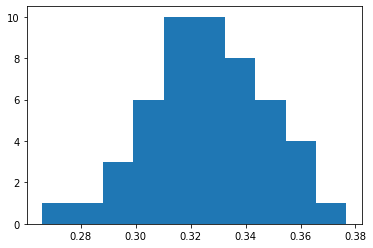

In [245]:
plt.hist(record_t)

In [233]:
np.mean(record_100)

0.3136329155674742

In [234]:
np.var(record_100)

0.00041397959960555176

In [250]:
np.mean(record_100)-1.96*np.sqrt(np.var(record_t))/(100)

0.3132140898522523

In [251]:
np.mean(record_100)+1.96*np.sqrt(np.var(record_t))/(100)

0.3140517412826961

In [202]:
RF_clf = RandomForestClassifier(min_samples_leaf=10)
#'criterion': 'gini'


In [203]:
RF_clf.fit(Train_X,Train_y)


/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [204]:
sum(RF_clf.predict(Train_X)==Train_y.reshape(-1))/len(Train_X)

0.906332877244548

In [205]:
sum(RF_clf.predict(Validation_X)==Validation_y.reshape(-1))/len(Validation_X)

0.8206726587416643

In [206]:
f1_score(Train_y.reshape(-1), RF_clf.predict(Train_X))

0.4778227705056973

In [207]:
f1_score(Validation_y.reshape(-1), RF_clf.predict(Validation_X))

0.29675952245594084

### 위를 보면 엄청나게 오버피팅

In [104]:
RF_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [76]:
# from sklearn.base import clone

In [77]:
'''
max_f_for_fun = 0.41
for i in range(200) :
    RF_clf.fit(Train_X,Train_y)
    new_score = f1_score(Validation_y.reshape(-1), RF_clf.predict(Validation_X))
    if new_score > max_f_for_fun :
        train_f_score = f1_score(Train_y.reshape(-1), RF_clf.predict(Train_X))
        max_f_for_fun = new_score
        submission = RF_clf.predict(Test_X)
'''

/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/

/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/envs/work/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ieunpyo/anaconda3/

KeyboardInterrupt: 

In [ ]:
'''
print(train_f_score)
print(max_f_for_fun)
'''

# HYPERPARAMETER TUNING

## Random Hyperparameter Grid


In [92]:
RF_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
n_estimators,max_features,max_depth

In [ ]:
random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
# Fit the random search model
rf_random.fit(Train_X, Train_y)

In [ ]:
rf_random.best_params_

In [ ]:
f1_score(Validation_y.reshape(-1),rf_random.predict(Validation_X))

In [ ]:
f1_score(Train_y.reshape(-1), RF_clf.predict(Train_X))

In [ ]:
#submission = RF_clf.predict(Test_X)
submission = pd.DataFrame(submission,columns=['fr_yn'])
submission['fr_yn'] = submission['fr_yn'].map({1:'Y', 0:'N'})

In [ ]:
submission.to_csv('화재예측과제_Submission.csv')

In [ ]:
train['urban']